In [1]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
from scipy.integrate import odeint 
import scipy.signal as signal 


import pickle 
import random as rand  
from numpy import random
#from dFlipFlop import DFlipFlop
#from acdc import ACDC  
#from repressilator import Repressilator
from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import os.path 


In [2]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_values, params, initial_conditions, dt = 0.001, mode = 0): 
		self.nParams = len(params)   
		self.params = params #model parameters
		self.parameter_values = parameter_values #allowed parameter ranges  
		self.y0 = initial_conditions 	
		self.dt = dt
		self.T = 48 #hours
		self.N = int(self.T/self.dt) 
		self.ts = np.linspace(0, self.T, self.N) 
		self.amp = 300 #[nM] 		
		self.per = self.T/8 	
		self.sample_rate 		= 0.0033333333 #Hz 
		self.samples_per_hour 	= (1/self.dt)		
		self.jump 				= int(self.samples_per_hour/(self.sample_rate*3600))  	 	
		self.ideal = self.amp*(np.sin(math.pi*(self.ts)/self.per - math.pi/2) + 1) 
		#number of samples for FFT		
		self.nS = self.N/self.jump 
		self.dF = self.sample_rate/self.nS  
		self.idealF = self.getFrequencies(self.ideal) 		 	
		thresholdOne = -(self.nS/2)*100 #10nM -+ from ideal signal harmonics       
		thresholdTwo = 100  
		self.minAmp = 10
		self.maxAmp = 6000 
		self.mode = mode    			
		self.modes = [self.eval]       
		self.threshold = thresholdOne  
		self.omega = 1 #nm^-1 
		if self.mode == 1:
			self.threshold = thresholdTwo
	
	#gets summed difference of arrayData
	@staticmethod 	
	def getDif(indexes, arrayData):	
		arrLen = len(indexes)
		sum = 0
		for i, ind in enumerate(indexes):
			if i == arrLen - 1:
				break
			sum += arrayData[ind] - arrayData[indexes[i + 1]]
			
		#add last peak - same as substracting it from zero 
		sum += arrayData[indexes[-1:]]  
		return sum   
		
	#gets standard deviation 
	@staticmethod 
	def getSTD(indexes, arrayData, window):
		numPeaks = len(indexes)
		arrLen = len(arrayData)
		sum = 0
		for ind in indexes:
			minInd = max(0, ind - window)
			maxInd = min(arrLen, ind + window)
			sum += np.std(arrayData[minInd:maxInd])  
			
		sum = sum/numPeaks 	
		return sum	 
	
	def getFrequencies(self, y):
		#fft sample rate: 1 sample per 5 minutes
		y = y[0::self.jump]  
		res = abs(fft.rfft(y))
		#normalize the amplitudes 
		res = res/math.ceil(self.nS/2) 
		return res

	def costOne(self, Y): 
		p1 = Y[:,1]   
		fftData = self.getFrequencies(p1)     
		
		diff = fftData - self.idealF         
		cost = -np.dot(diff, diff) 		
		return cost,	
		
	def costTwo(self, Y, getAmplitude = False): 
		p1 = Y[:,1]  
		fftData = self.getFrequencies(p1)      
		fftData = np.array(fftData) 
		#find peaks using very low threshold and minimum distance
		indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1)  
		#in case of no oscillations return 0 
		if len(indexes) == 0:     
			return 0,  
		#if amplitude is greater than 400nM
		amp = np.max(fftData[indexes])
		if amp > self.maxAmp: 
			return 0, 
		fitSamples = fftData[indexes]  			
		std = self.getSTD(indexes, fftData, 1)  
		diff = self.getDif(indexes, fftData)  
		cost = std + diff
		#print(cost)   
		if getAmplitude:
			return cost, amp
		return cost, 
		
	def isViableFitness(self, fit):
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval(point, getAmplitude=True)  
		if self.mode == 0:
			return self.isViableFitness(fitness[0]) 
			
		fit = fitness[0] 
		amp = 0
		if fit > 0:
			amp = fitness[1] 
		return self.isViableFitness(fit) and amp >= self.minAmp and amp <= self.maxAmp   
		
	#evaluates a candidate  
	def eval(self, candidate, getAmplitude = False): 
		Y = np.array(self.simulate(candidate)) 
		if self.mode == 0:
			return self.costOne(Y)  
		else:
			return self.costTwo(Y, getAmplitude)      
	
	#simulates a candidate
	def simulate(self, candidate): 
		return odeint(self.oscillatorModelOde, self.y0, self.ts, args=(candidate,))   		

	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = np.linspace(0, self.T, self.N)
			solutions = self.simulate(subject) 			
		#else:
			#ssa simulation
			#ts,Y = self.represilatorStochastic(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)

		plt.plot(t,solutions[:,0], color="b", label = 'P2')
		plt.plot(t,solutions[:,1], color="g", label = 'A')
		plt.plot(t,solutions[:,2], color="gold", label = 'P2A')
		plt.plot(t,solutions[:,3], color="r", label = 'P')
		plt.plot(t,solutions[:,4], color="cyan", label = 'B')
		plt.plot(t,solutions[:,5], color="black", label = 'PB')
	

		plt.xlabel('Time')
		plt.ylabel('Concentration')
		plt.ylim(top=110, bottom = -10)
		plt.legend()

		plt.show()
			 				

	def getTotalVolume(self):
		vol = 1.0
		for param in self.params:		
			vol = vol*(self.parameter_values[param]["max"] - self.parameter_values[param]["min"])
		return vol 

	def oscillatorModelOde(self, Y, t, can): 

		kon1 = can[0]
		koff1 = can[1]
		kcat1 = can[2]
		kon2 = can[3]
		koff2 = can[4]
		kcat2 = can[5]
		
		#initial conditions
		P2 = Y.item(0)
		A = Y.item(1)
		P2A = Y.item(2)
		P = Y.item(3)
		B = Y.item(4)
		PB = Y.item(5)
		
	
	    #phosphatase reaction A = phosphatase
		dP2dt = -kon1 * P2 * A + koff1 * P2A + kcat2 * PB
		dAdt = -kon1 * P2 * A + koff1 * P2A + kcat1 * P2A
		dP2Adt = kon1 * P2 * A - koff1 * P2A - kcat1 * P2A

		#kinase reaction B = kinase
		dPdt = -kon2 * P * B + koff2 * PB + kcat1 * P2A
		dBdt = -kon2 * P * B + koff2 * PB + kcat2 * PB
		dPBdt = kon2 * P * B - koff2 * PB - kcat2 * PB




		return([dP2dt,dAdt,dP2Adt,dPdt,dBdt,dPBdt])	
	
	def getPerAmp(self, subject, mode="ode", indx=0): 
		if mode == "ode":
			ts = np.linspace(0, self.T, self.N) 
			Y = self.simulate(subject)    				
		#else:
			#ts,Y = self.represilatorStochastic(subject) 
		ts = np.array(ts) 
		Y = np.array(Y) 
		sig = Y[:, indx]
		indx_max, properties = signal.find_peaks(sig, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)      
		indx_min, properties = signal.find_peaks(sig*-1, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)     

		amps = [] 
		pers = []   
		for i in range(min(len(indx_max), len(indx_min))):
			amps.append((sig[indx_max[i]] - sig[indx_min[i]])/2) 			
			if i + 1 < len(indx_max):
				pers.append(ts[indx_max[i + 1]] - ts[indx_max[i]])
			if i + 1 < len(indx_min):
				pers.append(ts[indx_min[i + 1]] - ts[indx_min[i]])
		
		if len(amps) > 0 and len(pers) > 0:
			amps = np.array(amps)   	
			pers = np.array(pers)  
			
			#print(amps)
			amp = np.mean(amps)	
			#print(pers) 
			per = np.mean(pers) 
		else:
			amp = 0
			per = 0  
		
		print("amp" + str(amp)) 
		print("per" + str(per))   	
		
		return per, amp 
	

In [3]:
'''
Regions consist of cloud of points and principal component that govern the direction of exploration  
''' 
class Region: 
	def __init__(self, points, model, label, depth=1):    
		self.points = np.array(points)  
		self.model = model  
		self.pca = PCA(n_components=self.model.nParams)
		self.components = None
		self.prevComponents = None 
		self.cluster = False
		self.terminated = False  
		self.iter = 0      
		self.maxIter = 10            
		self.threshold = 0.001    
		self.label = label
		self.maxVarScale = 4
		self.minVarScale = 2   
		self.varScaleDt = (self.maxVarScale - self.minVarScale)/(float(self.maxIter))    		     		
		self.varScale = self.maxVarScale         
		self.depth = depth     
		
	def updateVariance(self): 
		self.varScale = self.varScale - self.varScaleDt

	def updateIter(self):
		self.iter = self.iter + 1
		self.updateVariance()          	
		
	def fitPCA(self): 
		self.prevComponents = self.components 
		self.pca.fit(self.points)
		self.components = self.pca.components_
	
	def transform(self, points):  
		return self.pca.transform(points)  
		
	def inverse_transform(self, points):
		return self.pca.inverse_transform(points)   
		
	def converged(self):
		if self.components is None or self.prevComponents is None: 
			return False		
		return np.linalg.norm(self.components - self.prevComponents) < self.threshold   
		
	def explored(self):    
		return self.terminated or self.iter > self.maxIter or self.converged()   

In [4]:
'''
The main class
'''
class Solver:
	def __init__(self, model, populationSize=5000, NGEN = 10, nsamples = 1e5):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		
		for evalMode in self.model.modes: 
			nominalValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring): 
					if self.model.isViable(ind) and ind not in nominalValsMode:  
						nominalValsMode.append(ind)      
					ind.fitness.values = fit     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				print(rdm_ind)
				
				self.model.plotModel(rdm_ind)

				     
			
			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
		return nominalVals        
		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams): 
			candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"] or candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"]: 
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["min"]  
				if candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]:  
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		i = 0
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable 
			if self.model.isViable(point): 
				viable.append(point)   		
		return viable          
	
	# gap statistic method
	# returns the optimal number of clusters 	
	def gapStatistic(self, region, number_ref = 10, max_clusters = 2, plot = False):        
		#sample size is equal to the number of samples in gaussian sampling  
		sample_size = self.nsamples    
		subjects = np.array(region.points)                 
		gaps = []
		deviations = []   
		references = [] 
		clusters_range = range(1, max_clusters + 1) 
		
		transformed = region.transform(subjects) 
		#get min and max parameter values in pca space 
		minP = np.min(transformed, axis=0)  
		maxP = np.max(transformed, axis=0)   
		
		for gap_clusters in clusters_range:
			print(gap_clusters) 
			reference_inertia = []	
			for index in range(number_ref): 

				#OBB ... orientated bounding box 
				#random sampling within the PCA bounding box			
				reference = minP + random.rand(sample_size, self.model.nParams)*(maxP - minP)
				reference = region.inverse_transform(reference) 
				
				kmeanModel = KMeans(gap_clusters) 
				kmeanModel.fit(reference) 
				reference_inertia.append(kmeanModel.inertia_)    
			
			kmeanModel = KMeans(gap_clusters)      
			kmeanModel.fit(subjects)     
			log_ref_inertia = np.log(reference_inertia)	 
			#calculate gap
			gap = np.mean(log_ref_inertia) - np.log(kmeanModel.inertia_)  
			sk = math.sqrt(1 + 1.0/number_ref)*np.std(log_ref_inertia)  
			gaps.append(gap)    
			deviations.append(sk)        			
			
		# Plot the gaps   		
		if plot:
			plt.clf() 
			ax = plt.gca() 
			ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))	 
			ax.xaxis.set_major_locator(ticker.MultipleLocator(2))	
			lines = plt.errorbar(clusters_range, gaps, ecolor='dodgerblue', yerr=deviations, fmt='-', color='dodgerblue') 
			plt.setp(lines[0], linewidth=1.5)  
			plt.ylabel('Gaps')
			plt.show()  
			
		#return optimal number of clusters
		for k in range(0, max_clusters - 1): 
			if gaps[k] >= gaps[k + 1] - deviations[k + 1]: 
				print("Optimal number of clusters: " + str(k + 1)) 
				return k + 1     
		print("Optimal number of clusters: " + str(max_clusters))    	
		return max_clusters   

	
	#returns the viable volume for 
	def getViableVolume(self, viableRegions, sample_size = int(1e4)):
		volume = 0 

		for region in viableRegions:		
			regPoints = region.points
			region.fitPCA() 						 						
			transformed = region.transform(regPoints) 
		  		
			minP = np.min(transformed, axis=0)   
			maxP = np.max(transformed, axis=0)   
		
			dP = maxP - minP
			volB = np.prod(dP)			

			mcRef = minP + random.rand(sample_size, self.model.nParams)*dP  
			mcRef = region.inverse_transform(mcRef)	 		
			
			viaPoints = self.getViablePoints(mcRef) 
			count = np.ma.size(viaPoints, axis=0) 
			
			#volume for region  
			ratio = count/sample_size   
			volume = volume + ratio*volB  			
	
		print("Bounding box volume " + str(volB)) 
		print("Volume " + str(volume))   
		print("Total volume " + str(self.model.getTotalVolume()))   		
		print("Volume ratio:" + str(volume/self.model.getTotalVolume())) 
		return volume 

	def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
		colorLen = len(colors) 

		for i in range(nRegions): 
			col = colors[i % colorLen] 		 
			plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
			plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
			plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
			plt.setp(bp['fliers'][i], color=col) 
			plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
		
	def plotParameterVariances(self, viableSets, names=None, units=None):      
		#go through all parameters  
		params = self.model.params    
		figure = plt.figure()     
		nRows = math.ceil(len(params)/3)    
		for pcount, param in enumerate(params):    
			ax1 = plt.subplot(nRows, 3, pcount+1)  
			#if names == None:
			#	ax1.set_title(str(param) + str(pcount))    
			#else:
			#	ax1.set_title(names[pcount])  
			if units != None:
				plt.ylabel(names[pcount] + " " + units[pcount])  
			allRegions = [] 	
			#go through all regions 
			numSets = len(viableSets) 
			allNames = []
			allBoxes = []
			for count, reg in enumerate(viableSets): 
				points = np.array(reg.points)    
				data = points[:,pcount]   
				allRegions.append(data)   
				allNames.append("Region " + str(count + 1))   				
			bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4) 
			self.setBoxColors(bp, numSets, ax1) 		
			allBoxes = bp['boxes'] 
			
		#draw legend 
		figure.legend(allBoxes, allNames, 'lower right')
		plt.show()     
		
	#Main method  
	def run(self, filename, maxDepth=0):    
		#filename is a file to which viable sets will be serialized    

		#estimate the inital viable set 
		viablePoints = self.findNominalValues()         		                 		
		
		if not viablePoints: 
			print("No viable points found!")  
			return 
		
		
		
		#dump viable points to file  
		pickle.dump(viablePoints, open(filename + "ViableSet_IterGA.p", "wb+"))   
		
		reg = Region(viablePoints, self.model, "0")   
		reg.fitPCA() 
		
		fpca = PCA(n_components=2)  		 		
		fpca.fit(reg.points)
				
		viableSets = list() 
		viableSets.append(reg)  		  		 
		converged = False 		
		iter = 0 
		
		while not converged: 
			converged = True 			 		 	 					  	 
			iter += 1 
			print("Iteration: " + str(iter))  	
			for set in viableSets:   				
				set.updateIter() 
				#if set not already explored  
				if not set.explored():
					setSize = len(set.points) 
					print("Label: " + set.label)   
					print("Iter: " + str(set.iter))  
					print("Variance scaling factor: " + str(set.varScale))    								
					converged = False   					
					      
					#sample with 0 mean and scaled variance of prinicpal components       
					candidateSet = random.multivariate_normal([0]*self.model.nParams, np.diag(set.pca.explained_variance_)*set.varScale, self.nsamples)				
					candidateSet = set.inverse_transform(candidateSet)      
								
					#check if parameter values are not out of range  		
					inBounds = list() 
					for cand in candidateSet: 				
						if not self.checkOutAllBounds(cand): 
							inBounds.append(cand)  
					inBounds = np.array(inBounds)   		
					candidateSet = inBounds   
					
					X = fpca.transform(set.points) 
					Y = fpca.transform(candidateSet) 	 				
					fig = plt.figure(iter)  
					plt.clf()          
					plt.scatter(Y[:, 0], Y[:, 1], c="red", alpha=0.1, edgecolor='k', rasterized=True, label = "Candidate")  
					plt.scatter(X[:, 0], X[:, 1], c="cornflowerblue", alpha=0.8, edgecolor='k', rasterized=True, label = "Viable")  				
					
					plt.xlabel('PC 1')      
					plt.ylabel('PC 2')  
					plt.title("Iteration"+str(set.iter))  
					plt.legend()
					plt.savefig(filename + "Set" + set.label + "Iter" + str(set.iter) + ".pdf")        	 
					#identify viable points  
					viablePoints = np.array(self.getViablePoints(candidateSet)) 
					
					#if viable set is smaller than number of parameters do not accept it
					print("Number of viable points: " + str(len(viablePoints)))   
					
					if len(viablePoints) <= setSize/10:   						 
						#cluster if not enough points obtained with sampling    
						print("Clustering, insufficient number of points")   
						set.terminated = True      
						set.cluster = True           
					else:
						pickle.dump(candidateSet, open(filename + "_Region" + str(set.label) + "CandidateSet_Iter" + str(set.iter) +  ".p", "wb+"))     
						pickle.dump(viablePoints, open(filename + "_Region" + str(set.label) + "ViableSet_Iter" + str(set.iter) + ".p", "wb+"))  						
						set.points = viablePoints           
						set.fitPCA()     	 			
				#if set not already terminated, terminate it and cluster   
				elif not set.terminated:    
					set.terminated = True       
					set.cluster = True         					
						
			#clustering, check for new clusters        	            
			newViableSets = list()   
			for set in viableSets: 
				if set.cluster and (maxDepth == 0 or set.depth < maxDepth):   
					set.cluster = False    
					setLabel = set.label    
					setDepth = set.depth      
					#determine the optimal number of clusters
					print("Clustering set" + set.label)      
					k = self.gapStatistic(set)    
					if k > 1:     
						#cluster and divide sets based on clustering 
						#update the list of sets 
						converged = False     
						labels = KMeans(n_clusters = k).fit_predict(set.points)         
						for i in range(k): 
							ind = np.where(labels == i)[0]  
							points = set.points[ind]
							reg = Region(points, self.model, setLabel + str(i), depth=setDepth+1)         
							reg.fitPCA()      
							#append new region to new set  
							newViableSets.append(reg)       						 			
			#end of clustering					 
			viableSets.extend(newViableSets)     
		#end of while loop  

## USE THIS TO CHANGE PARAMETER RANGES

In [8]:
parameter_values = {  "kon1": {"min": 0, "max": 5},  
            "koff1": {"min": 0, "max": 5},             				        
            "kcat1": {"min": 0, "max": 5},         
            "kon2": {"min": 0, "max": 5},         
            "koff2": {"min": 0, "max": 5}, 
            "kcat2": {"min": 0, "max":5},      	
            }   	 

## USE THIS TO CHANGE INITIAL COPY NUMBERS

./real_oscillatorCostTwo
0


/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[1.0096236142166721, 1.3948996156679228, 0.7804967865520201, 0.9095918611737808, 3.158264835925198, 0.811511052158283]


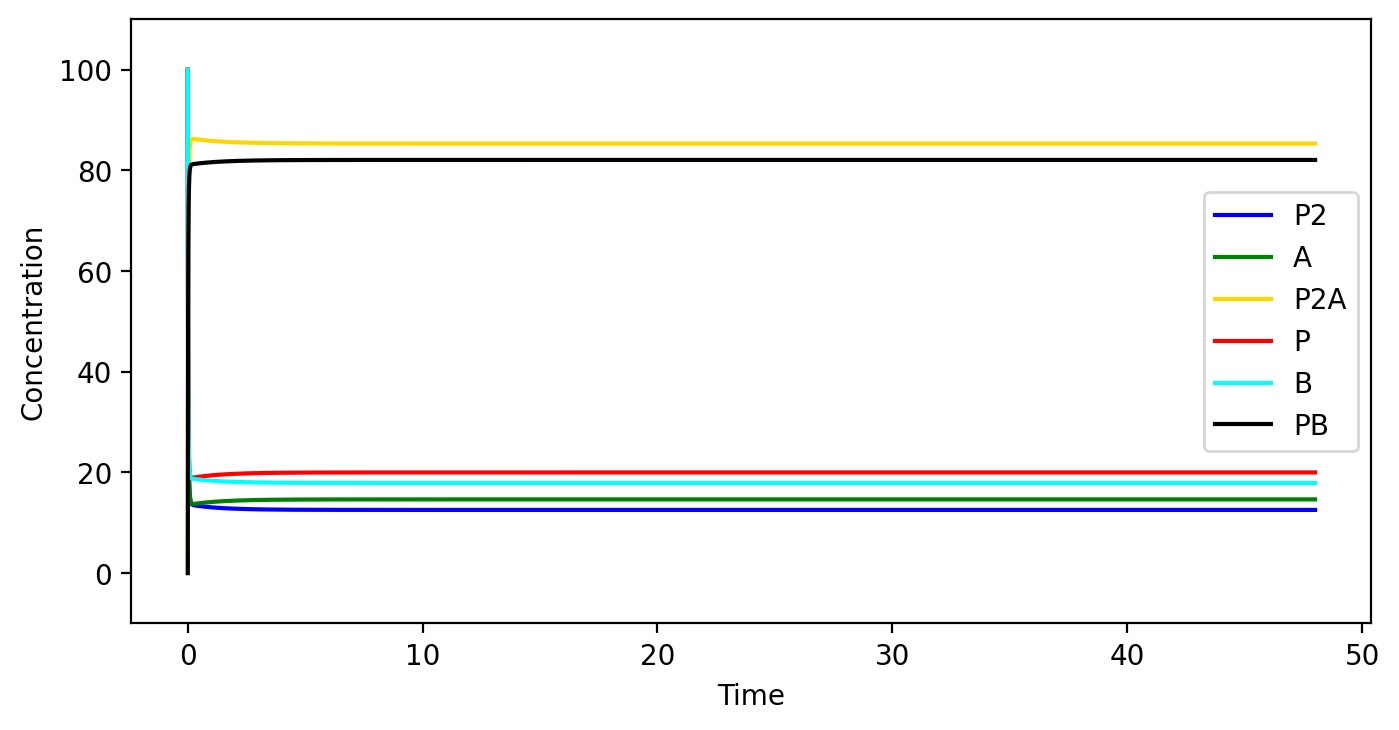

1
[0.17622962031871692, 0.6046799442226084, 0.9736352612921827, 2.7883272139467947, 2.693181674879433, 0.8435966803302358]


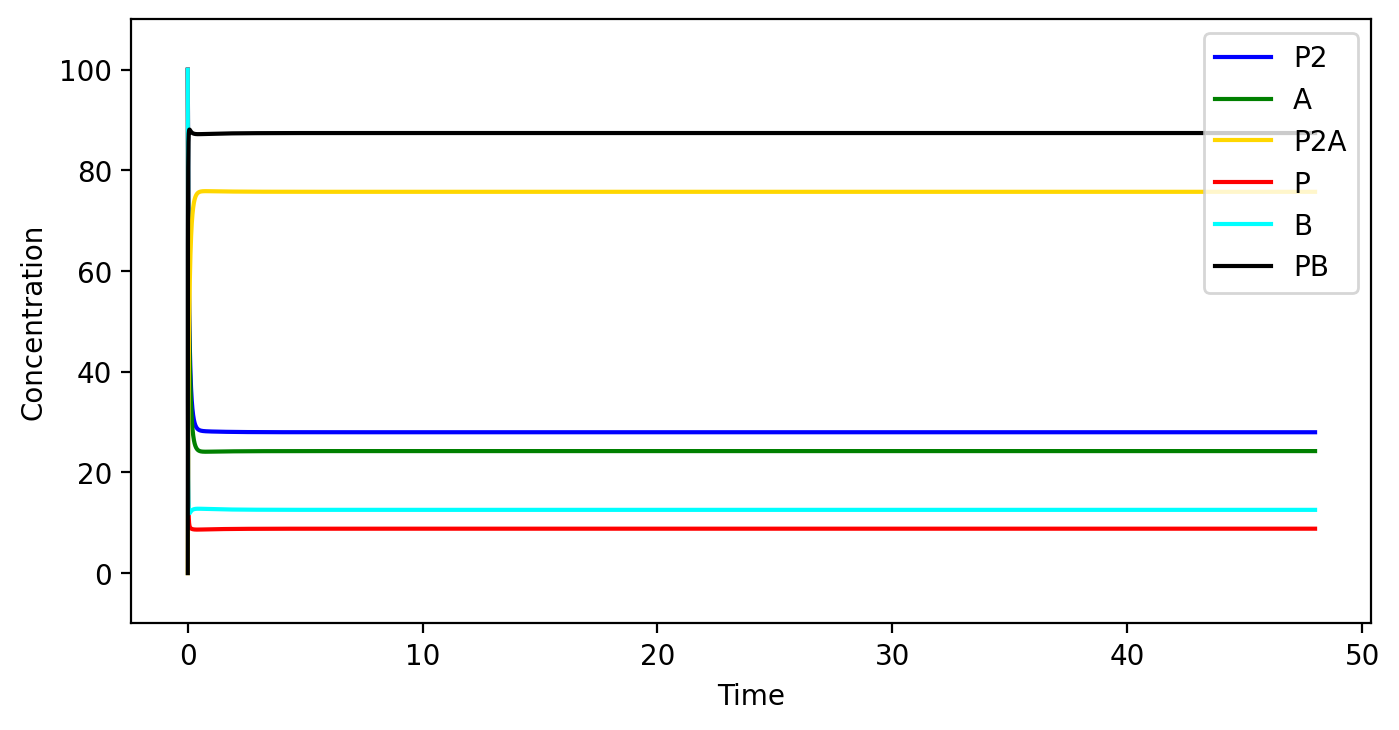

2
[0.09262693366400916, 0.31578857570027935, 0.9736352612921827, 2.180289501286669, 1.3407127818189124, 0.7969863594316423]


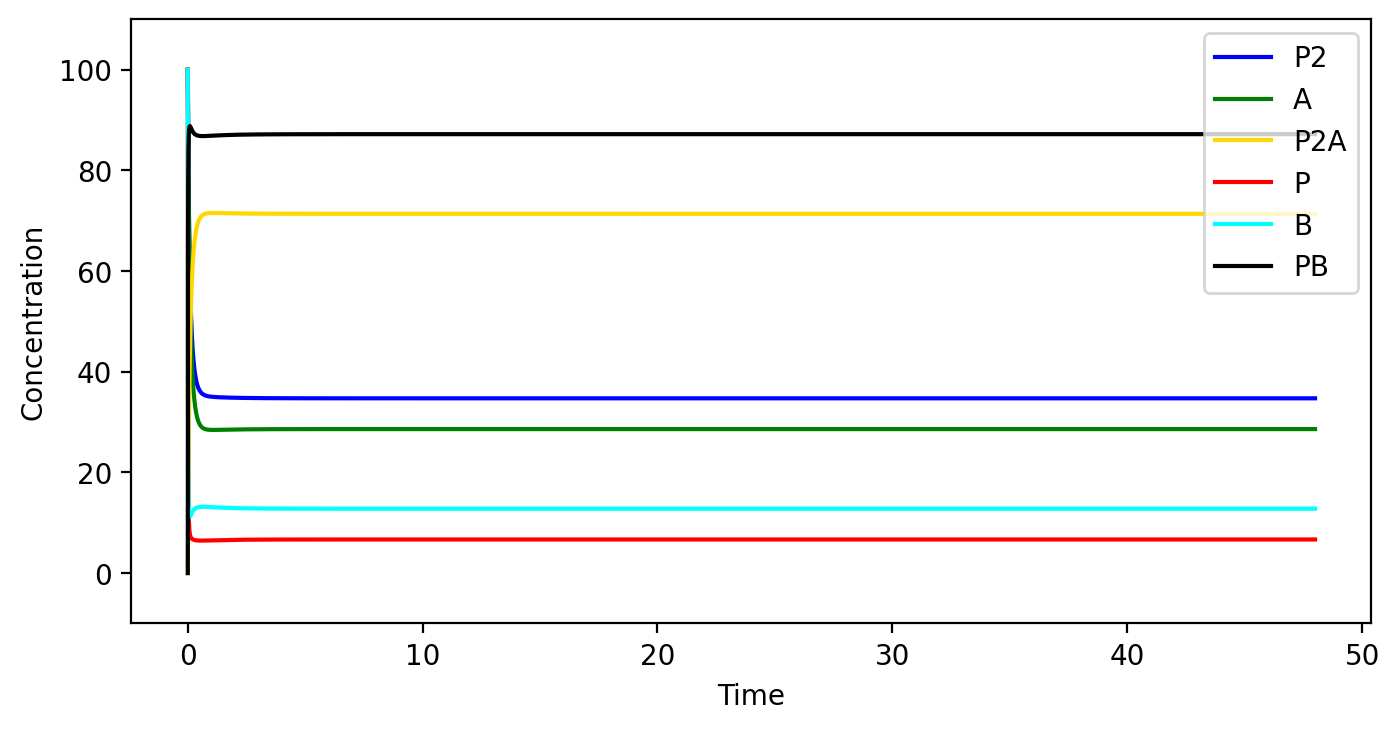

3
[0.03357036217674775, 0.15950206228529795, 0.642425349665596, 2.180289501286669, 1.9659202342971984, 0.41865776722872217]


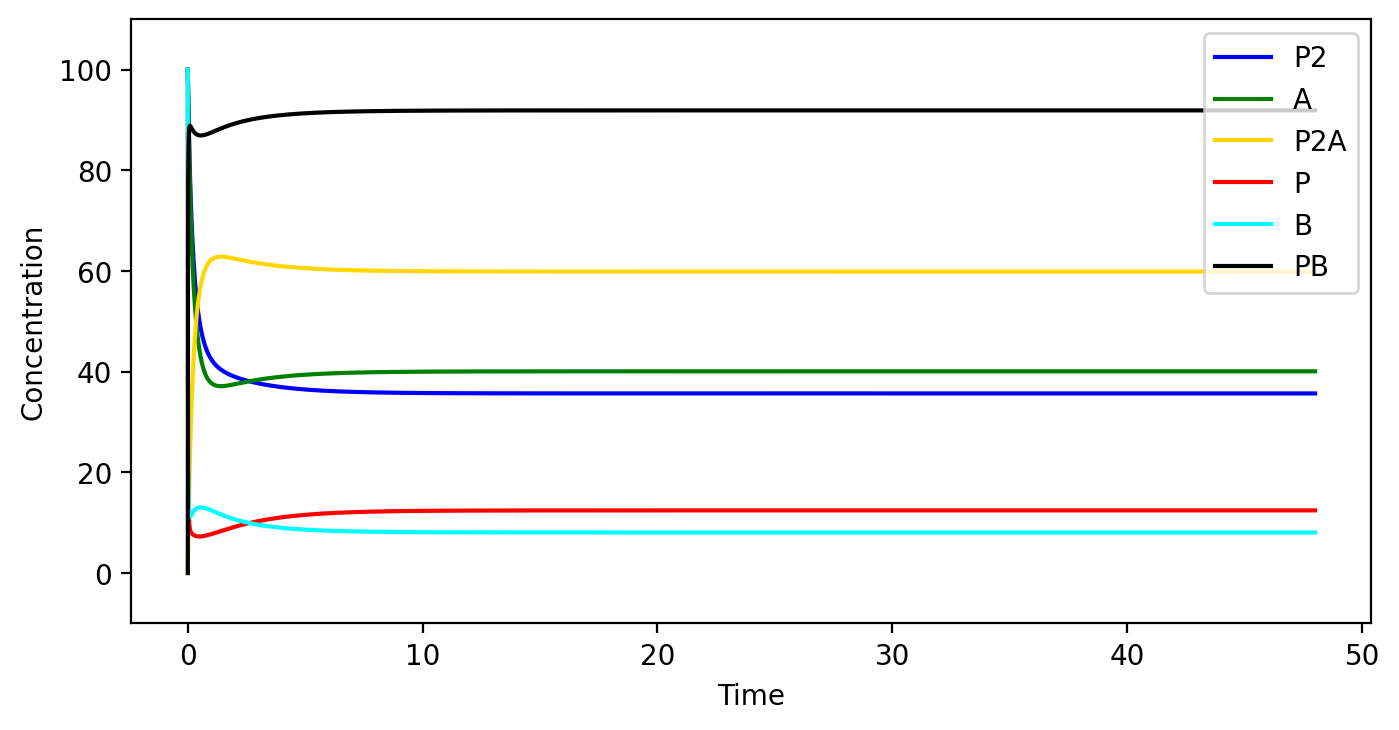

4
[0.01737113519083583, 0.15950206228529795, 0.642425349665596, 2.180289501286669, 2.5883032685740517, 0.41865776722872217]


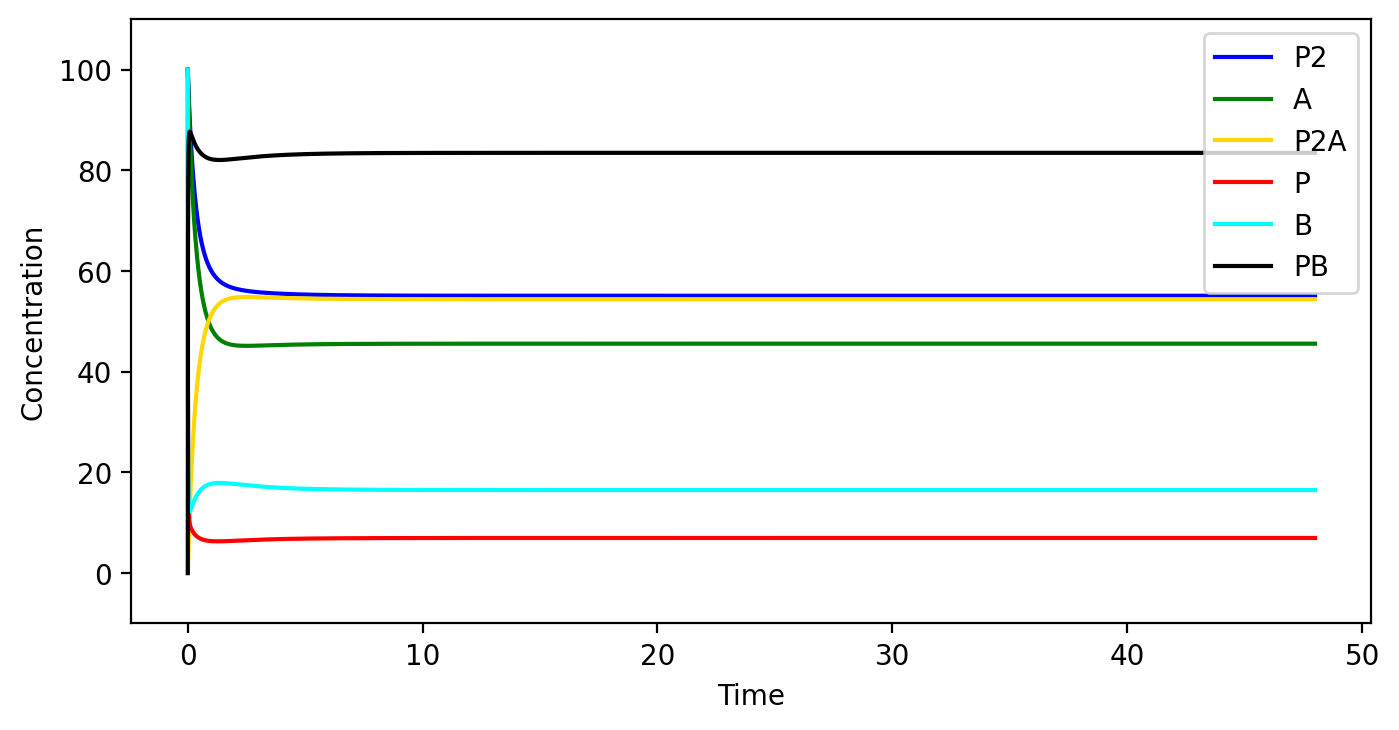

5
[0.020643070681395276, 0.05349069344919837, 0.5477947814943102, 2.180289501286669, 2.5063868016329374, 0.42569219808093894]


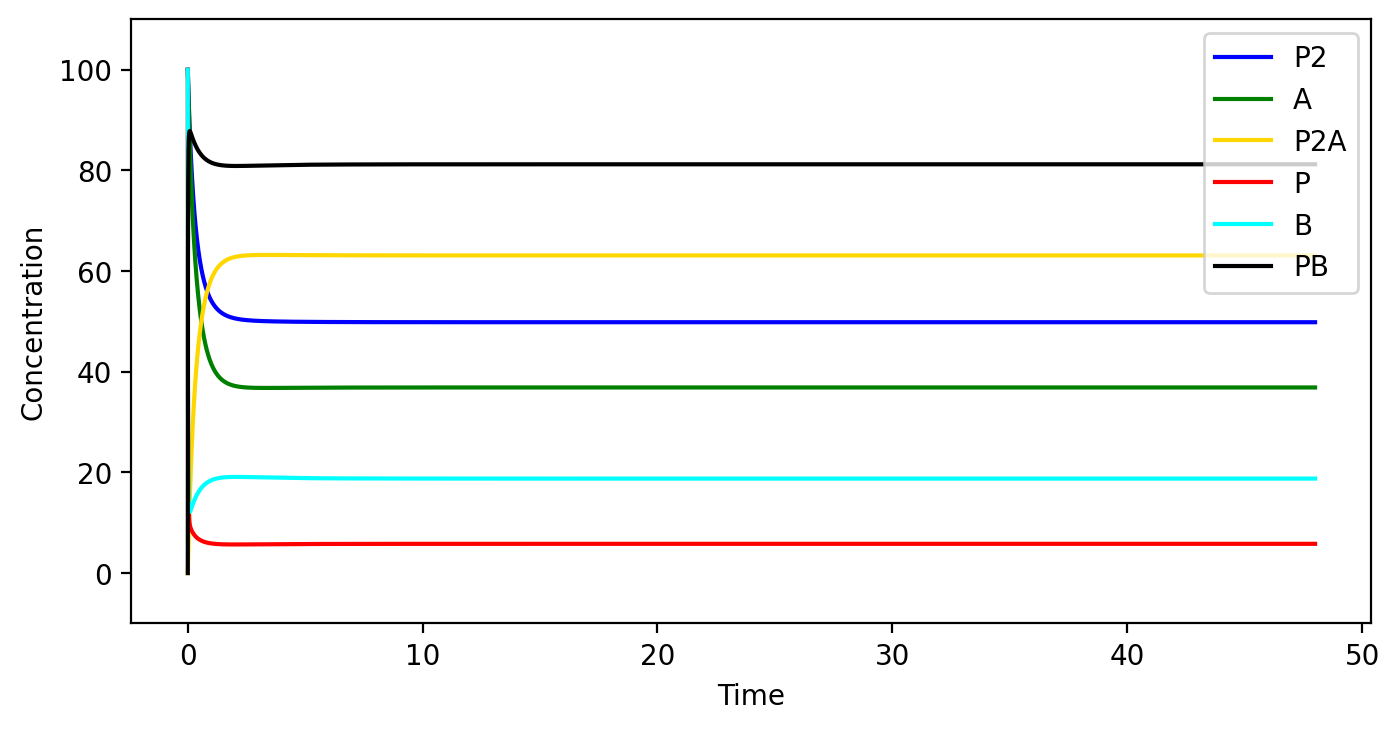

6
[0.020363040168529835, 0.09935060716546108, 0.3580984783211088, 2.180289501286669, 2.2139062888089813, 0.26819564994770934]


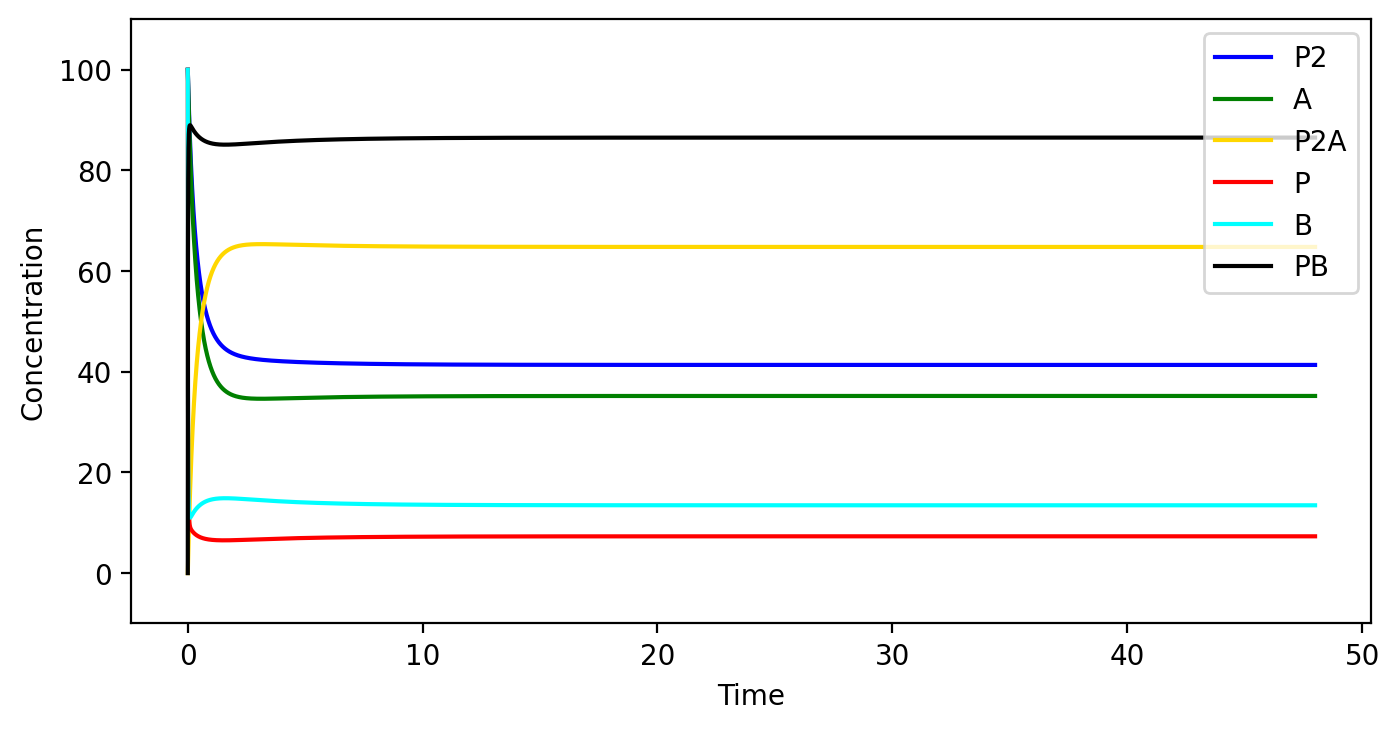

7
[0.012849759973339543, 0.05349069344919837, 0.30789044674797916, 1.68634692604244, 3.7443090776279737, 0.23177323847479664]


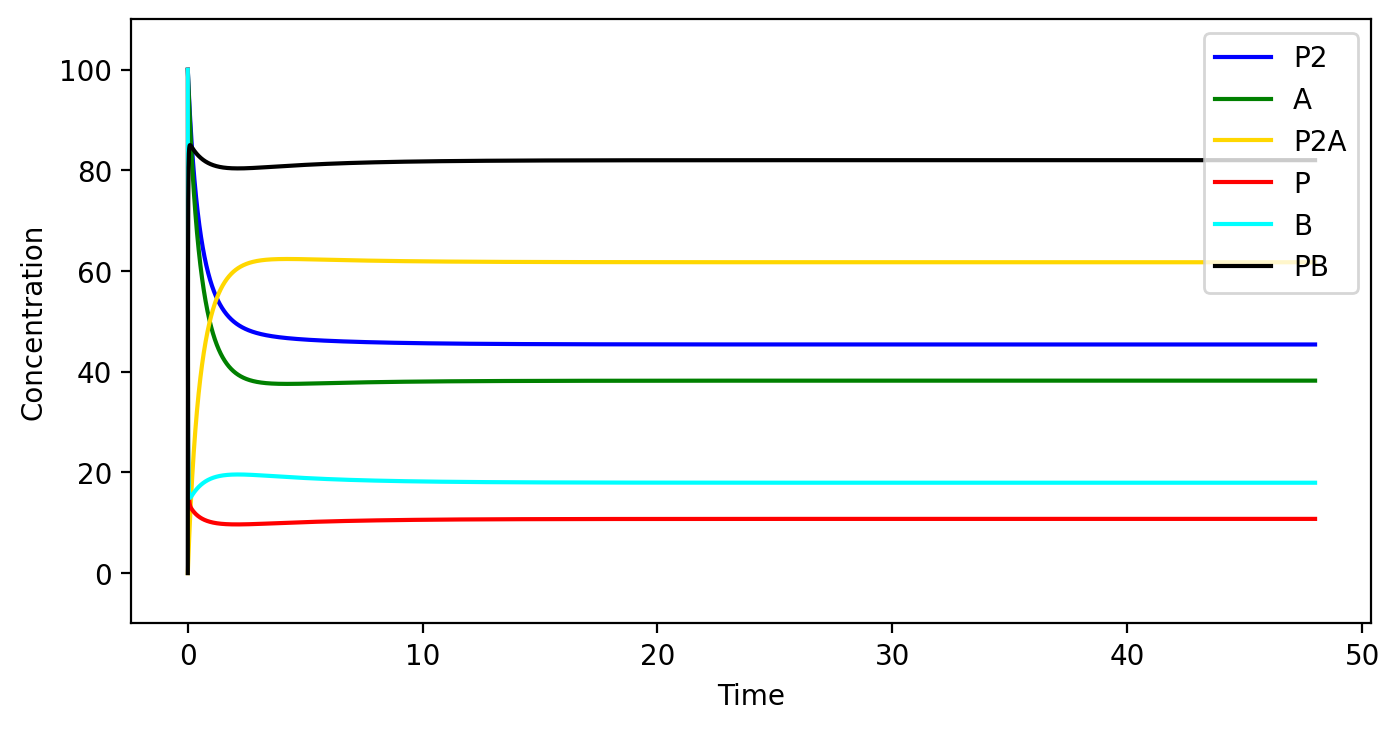

8
[0.013382672282865849, 0.05349069344919837, 0.18180278499382066, 1.5917233892182223, 1.9659202342971984, 0.147381997014153]


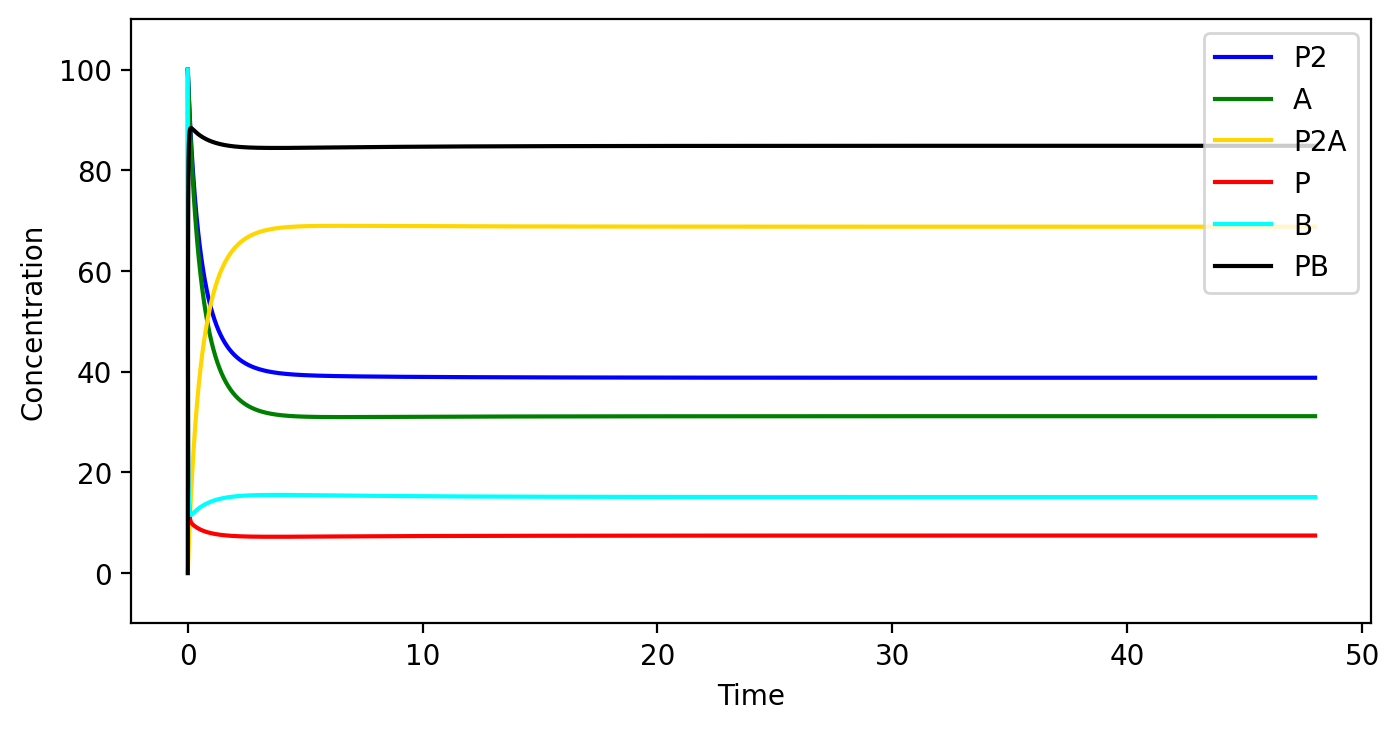

9
[0.00621323388779277, 0.0520646783512093, 0.18180278499382066, 1.5917233892182223, 2.9242135274308954, 0.12667386921170964]


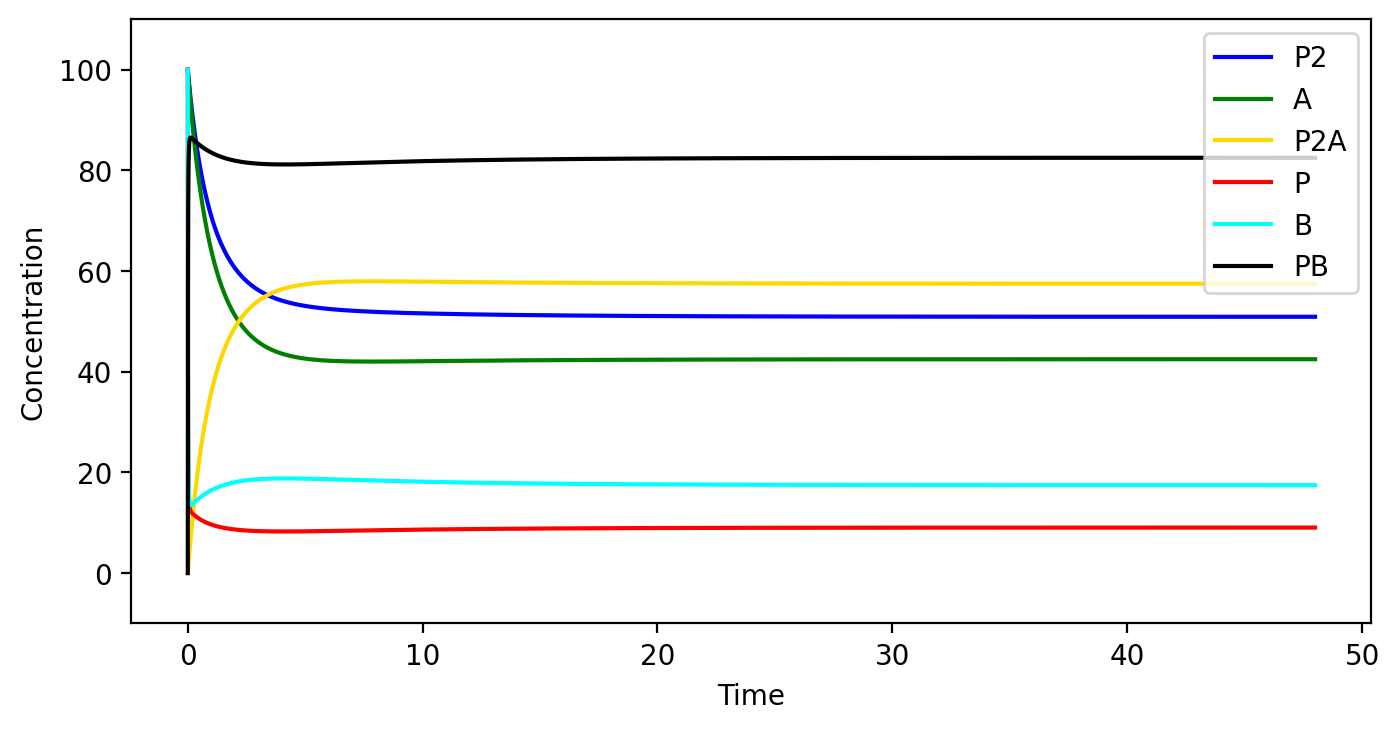

Number of viable points: 0
No viable points found!


In [9]:
filename =  os.path.join(".", "real_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["kon1","koff1","kcat1","kon2","koff2","kcat2"]), np.array([100,100,0,100,100,0]), mode=1)  
solver = Solver(model)         
solver.run(filename) 

# Analysis

/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
1
2
3
4
5
6
7
8
9
10
11


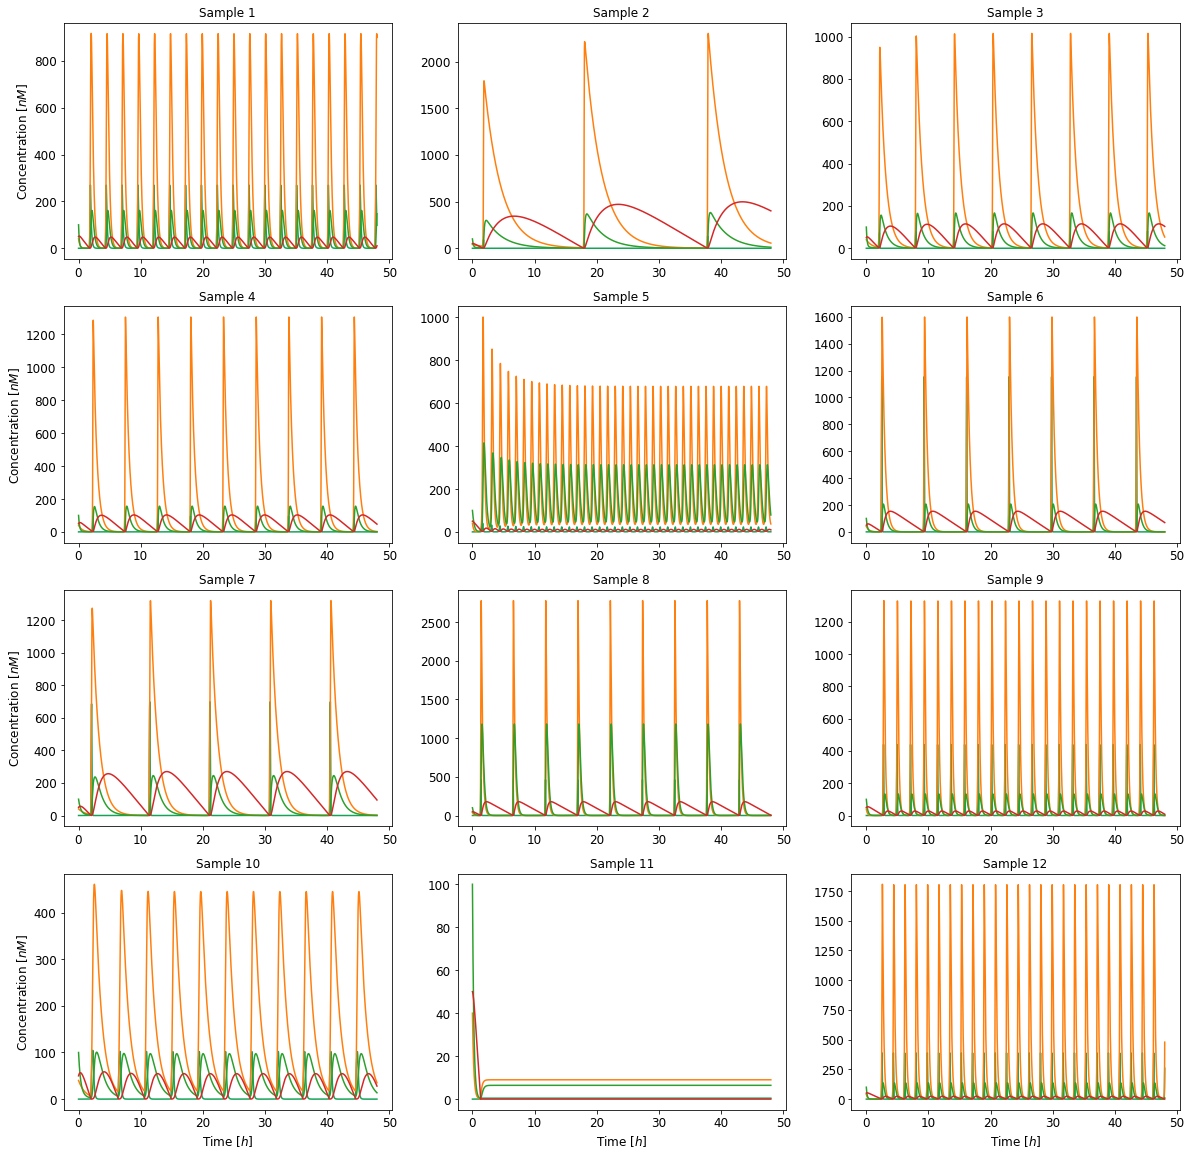

0
amp457.60180125596446
per2.5519061058870096
1
amp999.7804362332402
per18.615387820579596
2
amp500.4660912449168
per6.181282622875158
3
amp651.2863016927458
per5.252909435613242
4
amp334.00044894243354
per1.2299023352940859
5
amp799.0918025625438
per6.82959682872181
6
amp653.3015969219557
per9.631914950609088
7
amp1389.068501235537
per5.195241567532657
8
amp664.0881486917591
per2.173352970494577


In [46]:
plt.rcParams.update({'font.size': 12}) 

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Candidate", list, fitness=creator.FitnessMax)		
toolbox = base.Toolbox()	 
toolbox.register("candidate", Solver.generateCandidate) 
				
     
folder1 = os.path.join(".", "real_oscillatorCostTwo_Region0ViableSet_Iter10.p")      				
				
file1 =  folder1      
           

viablePoints2 = pickle.load(open(file1, "rb"))  
   

allViablePoints = viablePoints2
pca = PCA(n_components=2)
pca.fit(allViablePoints)

model2 = Oscillator(parameter_values, np.array(["ka2", "kb2", "ka3", "kb3", "ka4", "kb4", "kcat4", "ka5", "kb5", "kcat5", "ka6","kb6","ka7","kb7","ka8","kb8","kcat8"]), np.array([0,40,100,40,0,10,50,10,60]), mode=1) 

###                   ###
###  SSA simulations  ###
###                   ###  

#sample few random points from viable regions for region 2     
readFromFile = False                 

region2 = viablePoints2    
numSamples = 9
if readFromFile:
	sampleNumbers2 = pickle.load(open("stochastic_samples_numbers_repressilator", "rb"))
else:
	num2 = region2.shape[0]  
	sampleNumbers2 = np.random.choice(num2, numSamples, replace=False)   
	pickle.dump(sampleNumbers2, open("stochastic_samples_numbers_repressilator", "wb+"))    
	
#plot few simulations (ode + ssa)
t = np.linspace(0, model2.T, model2.N)
if readFromFile:
	samples = pickle.load(open("stochastic_samples_repressilator","rb"))     
else:	
	samples = region2[sampleNumbers2,:]
	pickle.dump(samples, open("stochastic_samples_repressilator", "wb+"))   
	
notWorking = samples[numSamples-3:numSamples,:] 
notWorking = np.copy(notWorking) 
notWorking[0,2] = 1 #low hill coefficient
notWorking[1,0] = 1 #low transcription 
notWorking[2,5] = 10 #high protein degradation   

allSamples = np.vstack((samples, notWorking)) 

ts_total_stochastic = [] 
Y_total_stochastic = []
t_total_ode = []
Y_total_ode = []



if readFromFile:
	t_total_ode, Y_total_ode = pickle.load(open("stochastic_simulations_repressilator", "rb"))  

plt.figure(figsize=(25,25))
for i in range(numSamples + 3): 
	print(i)  
	
	ax1=plt.subplot(4, 3, i + 1)

	ax1.set_title("Sample " + str(i + 1), fontsize=12)	 
	
	sample = allSamples[i] 
	if readFromFile:
		#ts = ts_total_stochastic[i]   
		#Y = Y_total_stochastic[i]  
		Y_ode = Y_total_ode[i]  
		t = t_total_ode[i]  
	else:
		#ts, Y = model2.represilatorStochastic(sample)
		#Y = Y/model2.omega 
		Y_ode = model2.simulate(sample)  
		#ts_total_stochastic.append(ts)
		#Y_total_stochastic.append(Y) 
		t_total_ode.append(t)  
		Y_total_ode.append(Y_ode) 
	
	lines = plt.plot(t, Y_ode[:,0], t, Y_ode[:,1], t, Y_ode[:,2], t, Y_ode[:,3], t, Y_ode[:,4], t, Y_ode[:,5], t, Y_ode[:,6], t, Y_ode[:,7], t, Y_ode[:,8]) #ts, Y[:,1])  
	plt.setp(lines[0], linestyle = "-", linewidth=1.5, alpha=1, c="#15A357")
	#plt.setp(lines[1], linewidth=1.5, alpha = 0.65, c="#15A357") 


		
	if i == 9 or i == 10 or i == 11:
		plt.xlabel(r"Time [$h$]")    
	if i == 0 or i == 3 or i == 6 or i == 9:
		plt.ylabel('Concentration [$nM$]')  
plt.savefig("time_series.png")  	
plt.show()


if not readFromFile:
	pickle.dump((t_total_ode, Y_total_ode) ,open("stochastic_simulations_repressilator", "wb+"))       	
	
#plot boxplots
repetitions = 100    
amps = []
pers = []      
ode_amps = []
ode_pers = []

if readFromFile:
	pers, amps = pickle.load(open("stochastic_persamps_repressilator","rb")) 
for i in range(numSamples): 
	print(i) 
	sample = samples[i]
	per, amp = model2.getPerAmp(sample, mode="ode", indx=1)   
	ode_amps.append(amp)   
	ode_pers.append(per)    
	
	#if not readFromFile:	
		#curra = []
		#currp = []
		#for j in range(repetitions):
			#per, amp = model2.getPerAmp(sample, mode="ssa", indx=1)  
			#amp = amp/model2.omega    
			#curra.append(amp)  
			#currp.append(per)   		
		#amps.append(curra) 
		#pers.append(currp) 

if not readFromFile:	
	pickle.dump((pers, amps), open("stochastic_persamps_repressilator", "wb+"))  

